In [1]:
import pandas as pd
import warnings
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")
import pandas_profiling as pdp
df=pd.concat([train,test],sort=False)


In [2]:
import pandas_profiling as pdp
def preprocess():
    train=pd.read_csv("train_data.csv")
    test=pd.read_csv("test_data.csv")
    df=pd.concat([train,test],sort=False)
    df.age=df.age.map(lambda x:57 if x>58 else x)
    df.num_child=df.num_child.map(lambda x:7 if x>7 else x)
    df.study_time=df.study_time.map(lambda x:17 if x>17 else x)
    df["familiy_num"]=1+df.partner+df.num_child
    arealist=list(train.groupby("area").mean().salary.sort_values().index)
    areadic={}
    for i,area in enumerate(arealist):
        areadic[area]=i+1
    df.area=df.area.map(areadic)
    df.position=df.position+1
    df.sex=df.sex-1
    df.salary=np.log(df.salary)
    df["agexposition"]=df.age*df.position.map(lambda x:1.5 if x==1 else x)
    df.education=df.education+1
#     df.drop(["sex"],axis=1)
    train=df.dropna().drop(["id"],axis=1)
    test=df[df.salary.isnull()].drop(["id"],axis=1)
    test=test.drop(["salary",],axis=1)
    X = train.drop(["salary"],axis=1)
    y = train.salary
    return X,y,test,df
X,y,test,df=preprocess()
#original 23.625521293118492
train=pd.concat([X,y],axis=1)

In [19]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error
# import lightgbm as lgb
# model=lgb.LGBMRegressor(**{'booster': 'gblinear',
#                            'iterations': 309, 'depth': 16, 'learning_rate': 0.1,
#                            'random_strength': 48, 'bagging_temperature': 19.715729096205934, 
#                            'od_type': 'Iter', 'od_wait': 26, 'lambda_l1': 0.726486176355415, 
#                            'lambda_l2': 0.00044177449020498015, 'num_leaves': 188,
#                            'feature_fraction': 0.9443254919883529, 'bagging_fraction': 0.9271673814820428, 
#                            'bagging_freq': 2, 'min_child_samples': 17})
# scores = []
# X1=X[X.position==1]
# X2=X[X.position==2]
# X3=X[X.position==3]
# X4=X[X.position==4]


,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,familiy_num,agexposition
0,2,44,45,1,1,2,2,24,2.0,1.6,9.2,4,88.0
1,3,31,28,0,0,0,1,13,9.0,0.7,12.4,1,93.0
2,3,36,26,0,0,0,3,14,4.0,0.4,16.9,1,108.0
3,1,22,47,1,0,0,1,4,3.0,0.4,6.1,1,33.0
4,1,25,14,1,0,0,2,5,3.0,0.2,4.9,1,37.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1,27,17,1,0,0,2,7,2.0,0.2,15.5,1,40.5
20996,1,22,44,1,0,0,1,4,3.0,0.2,13.4,1,33.0
20997,4,36,41,1,0,0,3,14,4.0,0.8,12.7,1,144.0
20998,1,21,35,1,1,2,2,0,1.0,1.0,10.9,4,31.5


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
model=lgb.LGBMRegressor(**{'booster': 'gblinear',
                           'iterations': 309, 'depth': 16, 'learning_rate': 0.1,
                           'random_strength': 48, 'bagging_temperature': 19.715729096205934, 
                           'od_type': 'Iter', 'od_wait': 26, 'lambda_l1': 0.726486176355415, 
                           'lambda_l2': 0.00044177449020498015, 'num_leaves': 188,
                           'feature_fraction': 0.9443254919883529, 'bagging_fraction': 0.9271673814820428, 
                           'bagging_freq': 2, 'min_child_samples': 17})
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())

# Learning

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [7]:
pdp.ProfileReport(df)

In [8]:
from sklearn.ensemble import RandomForestRegressor as RFR
import numpy as np
from sklearn.metrics import mean_absolute_error

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
score=mean_absolute_error(np.exp(valid_y),np.exp(rg.predict(valid_X)))
print(f'MAE:{score:4f}')
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))
col_names = test.columns.values
col_names_ = col_names[np.argsort(rg.feature_importances_)[::-1]]
col_names_

0.9550358215611071
MAE:23.610391
Feature Importances:
	position   : 0.010766
	age        : 0.003914
	area       : 0.014661
	sex        : 0.001050
	partner    : 0.013310
	num_child  : 0.012098
	education  : 0.045353
	service_length : 0.004315
	study_time : 0.004520
	commute    : 0.209512
	overtime   : 0.025041
	familiy_num : 0.024246
	agexposition : 0.631216


array(['agexposition', 'commute', 'education', 'overtime', 'familiy_num',
       'area', 'partner', 'num_child', 'position', 'study_time',
       'service_length', 'age', 'sex'], dtype=object)

In [17]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
model=lgb.LGBMRegressor()
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())


[22.764094288724273, 22.792014845341466, 23.487210364564227, 23.352820410841307, 22.616116417087895]
23.00245126531183
TRAIN: 0        6.059298
1        5.761833
2        5.878717
3        5.304851
4        5.182163
           ...   
20993    6.259815
20994    5.839074
20995    5.202552
20996    5.306884
20999    5.579963
Name: salary, Length: 16800, dtype: float64 TEST: 7        5.261116
8        6.075476
12       5.537743
16       5.584838
18       5.606268
           ...   
20982    5.715850
20988    5.546720
20992    6.415819
20997    5.898216
20998    5.462502
Name: salary, Length: 4200, dtype: float64
TRAIN: 0        6.059298
1        5.761833
2        5.878717
3        5.304851
4        5.182163
           ...   
20994    5.839074
20995    5.202552
20996    5.306884
20997    5.898216
20998    5.462502
Name: salary, Length: 16800, dtype: float64 TEST: 9        6.152704
20       5.809583
27       5.847002
31       6.106313
35       5.302814
           ...   
20976    5.589306
2098

# ModelSelection

 80%|████████  | 8/10 [00:55<00:08,  4.35s/it]

[00:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


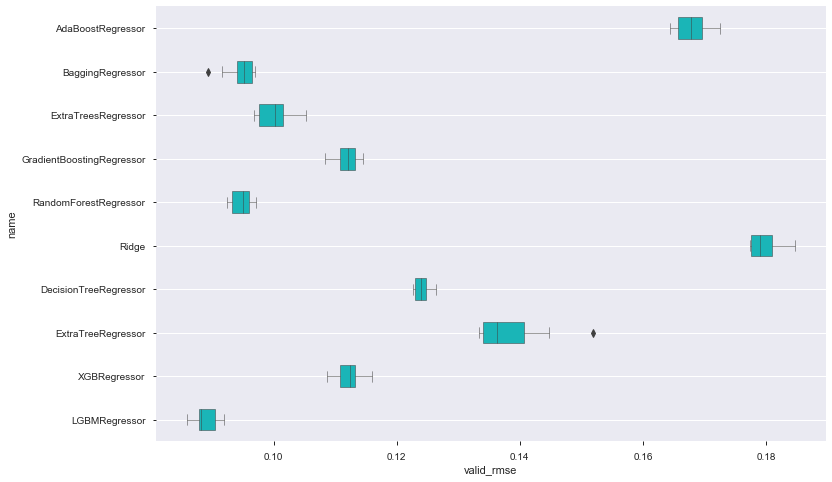

In [247]:
# 特徴量を選択して、複数のモデルで精度を調査する
from scipy.stats import mstats
from tqdm import tqdm
import matplotlib
from sklearn import metrics,  feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
# from imblearn import under_sampling, over_sampling
from sklearn.metrics import make_scorer
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
base_color = 'darkturquoise'
base_color2 = 'gray'

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)
cm = generate_cmap([base_color2, 'white', base_color])

def rmse_score(y_true, y_pred):
    """RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

params={'booster': 'dart', 
        'alpha': 0.009385870161072372, 
        'max_depth': 9, 'eta': 2.3698818355249718e-07,
        'gamma': 3.167530221746867e-05, 
        'grow_policy': 'lossguide',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 3.1207262366715483e-08,
        'skip_drop': 1.2650261386504368e-05}


models = [
 
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
 
    #Gaussian Processes
#     gaussian_process.GaussianProcessRegressor(),
    
    #GLM
    linear_model.Ridge(),

    
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
 
    #xgboost
    xgb. XGBRegressor(),
    lgb.LGBMRegressor(),
#     cat.CatBoostRegressor(),
    
]
 
df_compare = pd.DataFrame(columns=['name', 'train_rmse', 'valid_rmse', 'time'])
score_funcs = {
    'rmse': make_scorer(rmse_score),
}

for model in tqdm(models):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model,X,y, scoring=score_funcs, cv=10, return_train_score=True)
 
    for i in range(10):
        s = pd.Series([name, cv_rlts['train_rmse'][i], cv_rlts['test_rmse'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name=name+str(i))
        df_compare = df_compare.append(s)
        
plt.figure(figsize=(12,8))
sns.boxplot(data=df_compare, y='name', x='valid_rmse', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

 71%|███████▏  | 5/7 [00:42<00:16,  8.18s/it]

[00:26:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

100%|██████████| 7/7 [00:56<00:00,  8.04s/it]


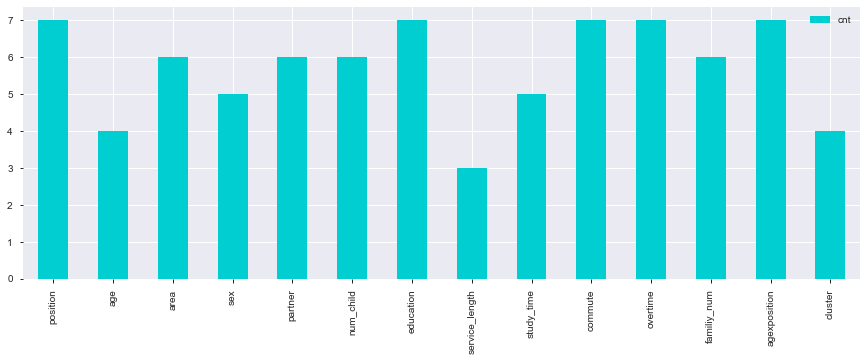

In [248]:
cols = X.columns.tolist()
 
# positive_cnt = int(df['salary'].sum())

feature_importance_models = [
    ensemble.AdaBoostRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    tree.DecisionTreeRegressor(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
]
 
scoring = ['rsme']
df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0
 
for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    rfe = feature_selection.RFECV(model, step=3)
    rfe.fit(X, y)
#     print(rfe.get_support())
    rfe_cols = X[cols].columns.values[rfe.get_support()]
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1
    
df_rfe_cols_cnt.plot(kind='bar', color=base_color, figsize=(15, 5))
plt.show()

In [386]:
x_cols = df_rfe_cols_cnt[df_rfe_cols_cnt['cnt'] < 4].index
X=X.drop(x_cols,axis=1)
test=test.drop(x_cols,axis=1)
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

## XGBoost+optuna

In [249]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import r2_score

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(r2_score(model.predict(X_test), y_test))

        score = np.array(scores).mean()
        return score

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 20)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=100)
# xgbr.fit(train_X, train_y)

# pred_y=xgbr.predict(valid_X)
# score=mean_absolute_error(np.exp(valid_y),np.exp(xgbr.predict(valid_X)))
# print(f'MAE:{score:4f}')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=3, shuffle=True, random_state=0)
model = XGBRegressorCV(n_trials=10)
scores = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())
#MAE:22.821581(drop)dummy
#MAE:22.753628(nodrop)dummy

[I 2019-11-20 00:28:36,513] Finished trial#0 resulted in value: 0.935196791185645. Current best value is 0.935196791185645 with parameters: {'booster': 'gbtree', 'alpha': 4.60033291811229e-06, 'max_depth': 18, 'eta': 0.008173817332634628, 'gamma': 0.8902721232594177, 'grow_policy': 'depthwise'}.
[I 2019-11-20 00:28:56,221] Finished trial#1 resulted in value: -1.5539921181251457. Current best value is 0.935196791185645 with parameters: {'booster': 'gbtree', 'alpha': 4.60033291811229e-06, 'max_depth': 18, 'eta': 0.008173817332634628, 'gamma': 0.8902721232594177, 'grow_policy': 'depthwise'}.
[I 2019-11-20 00:29:02,141] Finished trial#2 resulted in value: 0.9548856586697718. Current best value is 0.9548856586697718 with parameters: {'booster': 'gbtree', 'alpha': 0.00036957714154973493, 'max_depth': 7, 'eta': 8.476826495207648e-07, 'gamma': 1.8208331884593898e-08, 'grow_policy': 'lossguide'}.
[I 2019-11-20 00:29:15,208] Finished trial#3 resulted in value: -29.40068058137117. Current best va


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.0006344243075561812, 'max_depth': 8, 'eta': 1.0840048003283997e-08, 'gamma': 0.010909830452661298, 'grow_policy': 'depthwise'}

[00:29:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 00:30:17,791] Finished trial#0 resulted in value: 0.9521134752192577. Current best value is 0.9521134752192577 with parameters: {'booster': 'dart', 'alpha': 0.0005498199457683365, 'max_depth': 5, 'eta': 2.673192533142511e-07, 'gamma': 1.8888217914863087e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.270287350141747e-05, 'skip_drop': 7.760338396503087e-08}.
[I 2019-11-20 00:30:26,926] Finished trial#1 resulted in value: 0.9578058325024463. Current best value is 0.9578058325024463 with parameters: {'booster': 'gbtree', 'alpha': 1.1266429023874118e-06, 'max_depth': 10, 'eta': 0.0001753722465233045, 'gamma': 0.000261715475472335, 'grow_policy': 'depthwise'}.
[I 2019-11-20 00:30:48,396] Finished trial#2 resulted in value: 0.7272354906592282. Current best value is 0.9578058325024463 with parameters: {'booster': 'gbtree', 'alpha': 1.1266429023874118e-06, 'max_depth': 10, 'eta': 0.0001753722465233045, 'gamma': 0.00026171547547


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 1.1266429023874118e-06, 'max_depth': 10, 'eta': 0.0001753722465233045, 'gamma': 0.000261715475472335, 'grow_policy': 'depthwise'}

[00:32:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 00:33:19,903] Finished trial#0 resulted in value: 0.9540782183180527. Current best value is 0.9540782183180527 with parameters: {'booster': 'gbtree', 'alpha': 4.860611981540524e-07, 'max_depth': 16, 'eta': 0.09288159741639739, 'gamma': 4.111850153124893e-07, 'grow_policy': 'lossguide'}.
[I 2019-11-20 00:33:26,744] Finished trial#1 resulted in value: 0.9527068485401523. Current best value is 0.9540782183180527 with parameters: {'booster': 'gbtree', 'alpha': 4.860611981540524e-07, 'max_depth': 16, 'eta': 0.09288159741639739, 'gamma': 4.111850153124893e-07, 'grow_policy': 'lossguide'}.
[I 2019-11-20 00:33:34,972] Finished trial#2 resulted in value: -509.39465015773476. Current best value is 0.9540782183180527 with parameters: {'booster': 'gbtree', 'alpha': 4.860611981540524e-07, 'max_depth': 16, 'eta': 0.09288159741639739, 'gamma': 4.111850153124893e-07, 'grow_policy': 'lossguide'}.
[I 2019-11-20 00:34:26,887] Finished trial#3 resulted in value: 0.4727458439331976. Current b


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 1.6943165841563767e-07, 'max_depth': 14, 'eta': 0.0009645923293830843, 'gamma': 0.013461864078747363, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.7124916831359184e-08, 'skip_drop': 0.00012230598728643746}

[00:36:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22.95643615911303, 23.146576434969464, 22.742527656745942]
22.948513416942813


# LightGBM+optuna

In [420]:
# coding:utf-8
import lightgbm as lgb
# from sklearn.metrics import log_loss
def min_max_normalization(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / ( x_max - x_min)
    return x_norm
def min_max_renormalization(x1,x2):
    x_min = x2.min()
    x_max = x2.max()
#     x_norm = (x2 - x_min) / ( x_max - x_min)
    x=x1*  ( x_max - x_min)+x_min
    return x

import lightgbm as lgb
# from sklearn.metrics import log_loss
cat_list = ['area', 'sex', 'partner','education']
class LGBRegressorCV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'eval_metric':'mae',
            'booster':trial.suggest_categorical('booster',['gbtree','gblinear']),
            'loss_function': 'fair',
            'iterations' : trial.suggest_int('iterations', 50, 400),                      
#             'depth' : trial.suggest_int('depth', 4, 25),  
            'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50),
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressorCV(n_trials=20)
kf = KFold(n_splits=3, shuffle=True, random_state=0)
# model = XGBRegressorCV(n_trials=20)
scores = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_absolute_error(np.exp(model.predict(X_test)),np.exp( y_test)))
print(scores)
print(np.array(scores).mean())
# checktesty=valid_y.sort_values()
# checktestX=valid_X.ix[list(checktesty.index)]
# checktesty=checktesty.reset_index(drop=True)#これと

# checkpred=pd.DataFrame(model.predict(checktestX))#これ
# check=pd.concat([checktesty,checkpred], axis=1)
# check.columns=["actual","predict"]
# check.plot(alpha=0.5)
#MAE:23.144563 (nodrop)dummy
#MAE:23.742147(drop)dummy
#MAE:23.902507nodummy

[I 2019-11-20 14:49:33,001] Finished trial#0 resulted in value: 0.9444320369636955. Current best value is 0.9444320369636955 with parameters: {'booster': 'gbtree', 'iterations': 310, 'learning_rate': 0.5356748534001899, 'random_strength': 52, 'bagging_temperature': 0.17025341497792462, 'od_type': 'Iter', 'od_wait': 20, 'lambda_l1': 0.28916744743958905, 'lambda_l2': 2.6040951538148434e-07, 'num_leaves': 249, 'feature_fraction': 0.5161973959560417, 'bagging_fraction': 0.9864977088428162, 'bagging_freq': 2, 'min_child_samples': 69}.
[I 2019-11-20 14:49:35,601] Finished trial#1 resulted in value: 0.6812421248745195. Current best value is 0.9444320369636955 with parameters: {'booster': 'gbtree', 'iterations': 310, 'learning_rate': 0.5356748534001899, 'random_strength': 52, 'bagging_temperature': 0.17025341497792462, 'od_type': 'Iter', 'od_wait': 20, 'lambda_l1': 0.28916744743958905, 'lambda_l2': 2.6040951538148434e-07, 'num_leaves': 249, 'feature_fraction': 0.5161973959560417, 'bagging_frac


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 393, 'learning_rate': 0.08430886181317533, 'random_strength': 2, 'bagging_temperature': 3.7728812010310446, 'od_type': 'IncToDec', 'od_wait': 23, 'lambda_l1': 3.6060490924544417e-06, 'lambda_l2': 0.00013197746712333668, 'num_leaves': 57, 'feature_fraction': 0.6675434030420537, 'bagging_fraction': 0.5669304919807483, 'bagging_freq': 5, 'min_child_samples': 19}



[I 2019-11-20 14:50:22,203] Finished trial#0 resulted in value: 0.9190442462685363. Current best value is 0.9190442462685363 with parameters: {'booster': 'gbtree', 'iterations': 103, 'learning_rate': 0.7597808912677907, 'random_strength': 62, 'bagging_temperature': 50.66977343950774, 'od_type': 'Iter', 'od_wait': 22, 'lambda_l1': 7.434126748681443e-07, 'lambda_l2': 0.00351728452576551, 'num_leaves': 104, 'feature_fraction': 0.4508349977292094, 'bagging_fraction': 0.40809902352411337, 'bagging_freq': 3, 'min_child_samples': 73}.
[I 2019-11-20 14:50:26,060] Finished trial#1 resulted in value: 0.9561786264207287. Current best value is 0.9561786264207287 with parameters: {'booster': 'gblinear', 'iterations': 157, 'learning_rate': 0.12165360415228718, 'random_strength': 48, 'bagging_temperature': 0.6866054425106289, 'od_type': 'IncToDec', 'od_wait': 17, 'lambda_l1': 0.27329988248253806, 'lambda_l2': 6.850685344136793e-05, 'num_leaves': 212, 'feature_fraction': 0.8667216729716639, 'bagging_f

KeyboardInterrupt: 

In [419]:
    
class LGBRegressor1CV(RidgeCV):
    model_cls = lgb.LGBMRegressor
    def __call__(self, trial):
        params = {
            'loss_function': 'xentropy loss',
            'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 8, 20), 
#             'depth':16,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score

model=LGBRegressor1CV(n_trials=40)
train_ylgm=min_max_normalization(train_y)
model.fit(train_X,train_ylgm)

pred_y=min_max_renormalization(model.predict(valid_X),train_y)
score=mean_absolute_error(np.exp(valid_y),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test)


[I 2019-11-20 14:48:38,249] Finished trial#0 resulted in value: 0.9546877750924008. Current best value is 0.9546877750924008 with parameters: {'iterations': 101, 'learning_rate': 0.05677338448922201, 'random_strength': 74, 'bagging_temperature': 2.0510543184036862, 'od_type': 'Iter', 'od_wait': 35}.
[I 2019-11-20 14:48:40,445] Finished trial#1 resulted in value: 0.8725052547829868. Current best value is 0.9546877750924008 with parameters: {'iterations': 101, 'learning_rate': 0.05677338448922201, 'random_strength': 74, 'bagging_temperature': 2.0510543184036862, 'od_type': 'Iter', 'od_wait': 35}.
[I 2019-11-20 14:48:41,974] Finished trial#2 resulted in value: 0.956279653164976. Current best value is 0.956279653164976 with parameters: {'iterations': 77, 'learning_rate': 0.2861080183583399, 'random_strength': 8, 'bagging_temperature': 0.053753584042810526, 'od_type': 'IncToDec', 'od_wait': 11}.
[I 2019-11-20 14:48:43,704] Finished trial#3 resulted in value: 0.9526568224980487. Current best

KeyboardInterrupt: 

## CatBoost+optuna(non recomended)

In [433]:
from catboost import CatBoost
# from sklearn.metrics import log_loss

class CatRegressorCV(RidgeCV):
    model_cls = CatBoost
    def __call__(self, trial):
        params = {
            'loss_function': 'MAE',
#             'iterations' : trial.suggest_int('iterations', 50, 300),                      
            'depth' : trial.suggest_int('depth', 6, 10),                                      
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),               
            'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
            'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
        model=self.model_cls(params)
        score = self.kfold_cv(model)
        return score
# model=CatRegressorCV(n_trials=10)
model=CatBoost({'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
print(f'MAE:{score:4f}')
pred=model.predict(test)

0:	learn: 0.4311223	total: 6.09ms	remaining: 6.08s
1:	learn: 0.4122959	total: 15.3ms	remaining: 7.62s
2:	learn: 0.3929384	total: 24.4ms	remaining: 8.12s
3:	learn: 0.3781482	total: 30.1ms	remaining: 7.5s
4:	learn: 0.3617889	total: 44.7ms	remaining: 8.9s
5:	learn: 0.3479133	total: 58.7ms	remaining: 9.72s
6:	learn: 0.3305254	total: 70.5ms	remaining: 9.99s
7:	learn: 0.3156954	total: 83.6ms	remaining: 10.4s
8:	learn: 0.3049368	total: 93.7ms	remaining: 10.3s
9:	learn: 0.2948312	total: 103ms	remaining: 10.2s
10:	learn: 0.2851900	total: 113ms	remaining: 10.2s
11:	learn: 0.2806031	total: 123ms	remaining: 10.1s
12:	learn: 0.2729884	total: 132ms	remaining: 10.1s
13:	learn: 0.2656313	total: 142ms	remaining: 10s
14:	learn: 0.2601300	total: 151ms	remaining: 9.93s
15:	learn: 0.2539201	total: 170ms	remaining: 10.5s
16:	learn: 0.2485246	total: 183ms	remaining: 10.6s
17:	learn: 0.2423629	total: 195ms	remaining: 10.6s
18:	learn: 0.2380699	total: 247ms	remaining: 12.8s
19:	learn: 0.2347966	total: 288ms	re

161:	learn: 0.1260394	total: 2.13s	remaining: 11s
162:	learn: 0.1253762	total: 2.14s	remaining: 11s
163:	learn: 0.1245294	total: 2.15s	remaining: 11s
164:	learn: 0.1236547	total: 2.16s	remaining: 10.9s
165:	learn: 0.1226551	total: 2.17s	remaining: 10.9s
166:	learn: 0.1218153	total: 2.19s	remaining: 10.9s
167:	learn: 0.1210012	total: 2.2s	remaining: 10.9s
168:	learn: 0.1198229	total: 2.21s	remaining: 10.9s
169:	learn: 0.1186641	total: 2.21s	remaining: 10.8s
170:	learn: 0.1184452	total: 2.22s	remaining: 10.8s
171:	learn: 0.1174584	total: 2.23s	remaining: 10.7s
172:	learn: 0.1168594	total: 2.24s	remaining: 10.7s
173:	learn: 0.1160382	total: 2.25s	remaining: 10.7s
174:	learn: 0.1155777	total: 2.26s	remaining: 10.6s
175:	learn: 0.1149415	total: 2.27s	remaining: 10.6s
176:	learn: 0.1141265	total: 2.29s	remaining: 10.6s
177:	learn: 0.1138118	total: 2.31s	remaining: 10.6s
178:	learn: 0.1132746	total: 2.32s	remaining: 10.7s
179:	learn: 0.1129659	total: 2.34s	remaining: 10.7s
180:	learn: 0.11250

320:	learn: 0.0888810	total: 3.95s	remaining: 8.36s
321:	learn: 0.0888278	total: 3.96s	remaining: 8.35s
322:	learn: 0.0887025	total: 3.98s	remaining: 8.34s
323:	learn: 0.0886652	total: 3.98s	remaining: 8.32s
324:	learn: 0.0885920	total: 4s	remaining: 8.3s
325:	learn: 0.0885365	total: 4.01s	remaining: 8.29s
326:	learn: 0.0884819	total: 4.02s	remaining: 8.27s
327:	learn: 0.0884438	total: 4.03s	remaining: 8.26s
328:	learn: 0.0883378	total: 4.04s	remaining: 8.24s
329:	learn: 0.0883066	total: 4.05s	remaining: 8.23s
330:	learn: 0.0882703	total: 4.07s	remaining: 8.22s
331:	learn: 0.0882276	total: 4.08s	remaining: 8.2s
332:	learn: 0.0881350	total: 4.08s	remaining: 8.18s
333:	learn: 0.0880910	total: 4.1s	remaining: 8.17s
334:	learn: 0.0880187	total: 4.11s	remaining: 8.16s
335:	learn: 0.0879648	total: 4.12s	remaining: 8.14s
336:	learn: 0.0878786	total: 4.13s	remaining: 8.12s
337:	learn: 0.0878516	total: 4.13s	remaining: 8.1s
338:	learn: 0.0877520	total: 4.14s	remaining: 8.07s
339:	learn: 0.08769

479:	learn: 0.0819126	total: 5.59s	remaining: 6.05s
480:	learn: 0.0818823	total: 5.59s	remaining: 6.04s
481:	learn: 0.0818578	total: 5.6s	remaining: 6.02s
482:	learn: 0.0818371	total: 5.61s	remaining: 6s
483:	learn: 0.0818036	total: 5.62s	remaining: 5.99s
484:	learn: 0.0817769	total: 5.63s	remaining: 5.97s
485:	learn: 0.0817513	total: 5.64s	remaining: 5.96s
486:	learn: 0.0817293	total: 5.64s	remaining: 5.95s
487:	learn: 0.0817076	total: 5.65s	remaining: 5.93s
488:	learn: 0.0816822	total: 5.67s	remaining: 5.92s
489:	learn: 0.0816284	total: 5.68s	remaining: 5.91s
490:	learn: 0.0815935	total: 5.69s	remaining: 5.9s
491:	learn: 0.0815864	total: 5.7s	remaining: 5.88s
492:	learn: 0.0815727	total: 5.71s	remaining: 5.87s
493:	learn: 0.0815573	total: 5.72s	remaining: 5.86s
494:	learn: 0.0815413	total: 5.73s	remaining: 5.84s
495:	learn: 0.0815091	total: 5.82s	remaining: 5.92s
496:	learn: 0.0814835	total: 5.87s	remaining: 5.94s
497:	learn: 0.0814680	total: 5.99s	remaining: 6.04s
498:	learn: 0.0814

638:	learn: 0.0777096	total: 7.88s	remaining: 4.45s
639:	learn: 0.0776699	total: 7.89s	remaining: 4.44s
640:	learn: 0.0776200	total: 7.89s	remaining: 4.42s
641:	learn: 0.0776051	total: 7.9s	remaining: 4.41s
642:	learn: 0.0775866	total: 7.91s	remaining: 4.39s
643:	learn: 0.0775585	total: 7.91s	remaining: 4.37s
644:	learn: 0.0775452	total: 7.92s	remaining: 4.36s
645:	learn: 0.0775320	total: 7.92s	remaining: 4.34s
646:	learn: 0.0775059	total: 7.93s	remaining: 4.33s
647:	learn: 0.0774929	total: 7.94s	remaining: 4.32s
648:	learn: 0.0774865	total: 7.96s	remaining: 4.31s
649:	learn: 0.0774516	total: 7.98s	remaining: 4.3s
650:	learn: 0.0774122	total: 8s	remaining: 4.29s
651:	learn: 0.0773967	total: 8.01s	remaining: 4.27s
652:	learn: 0.0773711	total: 8.04s	remaining: 4.27s
653:	learn: 0.0773426	total: 8.06s	remaining: 4.27s
654:	learn: 0.0773192	total: 8.07s	remaining: 4.25s
655:	learn: 0.0773029	total: 8.09s	remaining: 4.24s
656:	learn: 0.0772901	total: 8.09s	remaining: 4.22s
657:	learn: 0.077

797:	learn: 0.0747011	total: 9.31s	remaining: 2.36s
798:	learn: 0.0746856	total: 9.32s	remaining: 2.35s
799:	learn: 0.0746578	total: 9.33s	remaining: 2.33s
800:	learn: 0.0746125	total: 9.34s	remaining: 2.32s
801:	learn: 0.0745864	total: 9.35s	remaining: 2.31s
802:	learn: 0.0745643	total: 9.36s	remaining: 2.29s
803:	learn: 0.0745479	total: 9.36s	remaining: 2.28s
804:	learn: 0.0745386	total: 9.37s	remaining: 2.27s
805:	learn: 0.0745288	total: 9.38s	remaining: 2.26s
806:	learn: 0.0745143	total: 9.39s	remaining: 2.25s
807:	learn: 0.0745050	total: 9.4s	remaining: 2.23s
808:	learn: 0.0744827	total: 9.4s	remaining: 2.22s
809:	learn: 0.0744600	total: 9.41s	remaining: 2.21s
810:	learn: 0.0744410	total: 9.42s	remaining: 2.2s
811:	learn: 0.0744283	total: 9.44s	remaining: 2.19s
812:	learn: 0.0743981	total: 9.45s	remaining: 2.17s
813:	learn: 0.0743852	total: 9.46s	remaining: 2.16s
814:	learn: 0.0743754	total: 9.47s	remaining: 2.15s
815:	learn: 0.0743592	total: 9.48s	remaining: 2.14s
816:	learn: 0.0

956:	learn: 0.0721371	total: 10.8s	remaining: 484ms
957:	learn: 0.0721162	total: 10.8s	remaining: 472ms
958:	learn: 0.0720910	total: 10.8s	remaining: 461ms
959:	learn: 0.0720777	total: 10.8s	remaining: 450ms
960:	learn: 0.0720675	total: 10.8s	remaining: 438ms
961:	learn: 0.0720430	total: 10.8s	remaining: 427ms
962:	learn: 0.0720237	total: 10.8s	remaining: 415ms
963:	learn: 0.0720122	total: 10.8s	remaining: 404ms
964:	learn: 0.0719990	total: 10.8s	remaining: 392ms
965:	learn: 0.0719877	total: 10.8s	remaining: 381ms
966:	learn: 0.0719730	total: 10.8s	remaining: 370ms
967:	learn: 0.0719579	total: 10.8s	remaining: 358ms
968:	learn: 0.0719401	total: 10.8s	remaining: 347ms
969:	learn: 0.0719309	total: 10.9s	remaining: 336ms
970:	learn: 0.0719133	total: 10.9s	remaining: 324ms
971:	learn: 0.0718980	total: 10.9s	remaining: 313ms
972:	learn: 0.0718867	total: 10.9s	remaining: 302ms
973:	learn: 0.0718669	total: 10.9s	remaining: 290ms
974:	learn: 0.0718536	total: 10.9s	remaining: 279ms
975:	learn: 

# Randomforest +optuna

In [490]:
class RFRegressorCV(RidgeCV):
    model_cls =  RFR
    def __call__(self, trial):
        params = {
            'n_estimators'      : trial.suggest_int('n_estimators', 10, 200),
            'max_features'      : trial.suggest_int('max_features', 1,self.X.shape[1]),
            'random_state'      : 123,
            'n_jobs'            : 1,
            'min_samples_split' :trial.suggest_int('min_samples_split', 3, 100) ,
            'max_depth'         : trial.suggest_int('max_depth' , 3, 100)
        }
        model=self.model_cls(**params)
        score = self.kfold_cv(model)
        return score
model=RFRegressorCV(n_trials=20)
#{'depth': 7, 'learning_rate': 0.074638569770399, 'random_strength': 59, 'bagging_temperature': 0.011038111194790014, 'od_type': 'IncToDec', 'od_wait': 12})
# model=CatBoost({'depth':16,'learning_rate': 0.05235680460545009, 'random_strength': 68, 'bagging_temperature': 0.5832808626920046, 'od_type': 'IncToDec', 'od_wait': 10, })
model.fit(train_X,train_y)

pred_y=model.predict(valid_X)
score=mean_absolute_error(np.exp(valid_y),np.exp(model.predict(valid_X)))
print(f'MAE:{score:4f}')
pred=model.predict(test)

[I 2019-11-20 19:48:02,789] Finished trial#0 resulted in value: 0.8931599296970697. Current best value is 0.8931599296970697 with parameters: {'n_estimators': 135, 'max_features': 1, 'min_samples_split': 12, 'max_depth': 85}.
[I 2019-11-20 19:48:23,929] Finished trial#1 resulted in value: 0.9566515640548288. Current best value is 0.9566515640548288 with parameters: {'n_estimators': 93, 'max_features': 12, 'min_samples_split': 9, 'max_depth': 54}.
[I 2019-11-20 19:48:32,150] Finished trial#2 resulted in value: 0.9458261198997718. Current best value is 0.9566515640548288 with parameters: {'n_estimators': 93, 'max_features': 12, 'min_samples_split': 9, 'max_depth': 54}.
[I 2019-11-20 19:48:43,064] Finished trial#3 resulted in value: 0.9380937454515014. Current best value is 0.9566515640548288 with parameters: {'n_estimators': 93, 'max_features': 12, 'min_samples_split': 9, 'max_depth': 54}.
[I 2019-11-20 19:48:45,291] Finished trial#4 resulted in value: 0.874440118510343. Current best val

KeyboardInterrupt: 

## Data engeneering for NN

In [404]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
categorical_variable_names = ["position","sex","education"]
# カテゴリ変数に一括変換
# x_dummy = pd.get_dummies(df[categorical_variable_names], drop_first=True,columns=categorical_variable_names)
# X_nn=df.drop(categorical_variable_names, axis=1)
X_nn=df
sscaler =StandardScaler()
sscaler.fit(X_nn)  

x_datas_std =sscaler.transform(X_nn)
x_datas_std = pd.DataFrame(x_datas_std, columns=X_nn.columns)
X_nn= pd.concat([x_datas_std,], axis=1)


train_X_nn=X_nn.drop("id",axis=1)
test_nn=X_nn[X_nn.salary.isnull()].drop("id",axis=1)
test_nn= test_nn.drop(["salary",],axis=1)
train_X_nn= train_X_nn.dropna().drop(["salary"],axis=1)

In [405]:
train_X_nn

,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,familiy_num,agexposition
0,-0.176420,1.027084,1.544468,1.009041,0.998734,0.708483,-0.085928,1.097992,-0.537098,0.818742,-0.243349,0.832908,-0.008975
1,0.643375,-0.192567,0.292875,-0.991040,-1.001267,-0.708058,-0.982563,0.069682,1.584501,-0.539406,0.283116,-0.833279,0.070094
2,0.643375,0.276529,0.145629,-0.991040,-1.001267,-0.708058,0.810708,0.163165,0.069073,-0.992122,1.023458,-0.833279,0.307300
3,-0.996214,-1.036941,1.691715,1.009041,-1.001267,-0.708058,-0.982563,-0.771663,-0.234012,-0.992122,-0.753363,-0.833279,-0.878731
4,-0.996214,-0.755483,-0.737849,1.009041,-1.001267,-0.708058,-0.085928,-0.678180,-0.234012,-1.293932,-0.950787,-0.833279,-0.807569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-0.996214,-0.567845,-0.516979,1.009041,-1.001267,-0.708058,-0.085928,-0.491214,-0.537098,-1.293932,0.793129,-0.833279,-0.760128
20996,-0.996214,-1.036941,1.470845,1.009041,-1.001267,-0.708058,-0.982563,-0.771663,-0.234012,-1.293932,0.447636,-0.833279,-0.878731
20997,1.463169,0.276529,1.249976,1.009041,-1.001267,-0.708058,0.810708,0.163165,0.069073,-0.388501,0.332472,-0.833279,0.876595
20998,-0.996214,-1.130761,0.808237,1.009041,0.998734,0.708483,-0.085928,-1.145594,-0.840184,-0.086690,0.036335,0.832908,-0.902451


In [406]:
#ニューラルネットワークモデルの生成
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(800, activation = 'relu'))
model.add(Dense(100, activation =  'relu'))
model.add(Dense(1))
# モデルをコンパイル 
from keras.optimizers import Adam
# ylgm=min_max_normalization(y)
train_X_nn, valid_X_nn,train_y_nn, valid_y_nn = train_test_split(train_X_nn,y,test_size=0.2,random_state=43)

model.compile(Adam(lr=1e-3), loss="mean_squared_error")
#トレーニングデータで学習し，テストデータで評価（平均2乗誤差を用いる）
history = model.fit(np.array(train_X_nn), np.array(train_y_nn), batch_size=128, epochs=100, verbose=1, 
          validation_data=(np.array(valid_X_nn), np.array(valid_y_nn)))

Train on 16800 samples, validate on 4200 samples
Epoch 1/100
16800/16800 [==============================] - ETA: 31s - loss: 32.925 - ETA: 13s - loss: 24.315 - ETA: 9s - loss: 16.529 - ETA: 6s - loss: 12.08 - ETA: 5s - loss: 9.5510 - ETA: 4s - loss: 7.818 - ETA: 4s - loss: 6.887 - ETA: 3s - loss: 6.059 - ETA: 3s - loss: 5.394 - ETA: 3s - loss: 4.912 - ETA: 3s - loss: 4.621 - ETA: 3s - loss: 4.368 - ETA: 2s - loss: 4.060 - ETA: 2s - loss: 3.879 - ETA: 2s - loss: 3.705 - ETA: 2s - loss: 3.481 - ETA: 2s - loss: 3.279 - ETA: 2s - loss: 3.098 - ETA: 2s - loss: 2.938 - ETA: 2s - loss: 2.839 - ETA: 2s - loss: 2.749 - ETA: 2s - loss: 2.664 - ETA: 2s - loss: 2.587 - ETA: 2s - loss: 2.509 - ETA: 2s - loss: 2.438 - ETA: 1s - loss: 2.339 - ETA: 1s - loss: 2.276 - ETA: 1s - loss: 2.218 - ETA: 1s - loss: 2.162 - ETA: 1s - loss: 2.109 - ETA: 1s - loss: 2.035 - ETA: 1s - loss: 1.989 - ETA: 1s - loss: 1.924 - ETA: 1s - loss: 1.882 - ETA: 1s - loss: 1.823 - ETA: 1s - loss: 1.785 - ETA: 1s - loss: 1.749 

16800/16800 [==============================] - ETA: 3s - loss: 0.020 - ETA: 7s - loss: 0.015 - ETA: 8s - loss: 0.019 - ETA: 5s - loss: 0.019 - ETA: 4s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.016 - ETA: 5s - loss: 0.014 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.015 - ETA: 5s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.015 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.014 - ETA: 4s - loss: 0.012 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.013 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.011 - ETA: 6s - loss: 0.011 - ETA: 5s - loss: 0.012 - ETA: 5s - loss: 0.011 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.012 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 4s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.010 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 6s - loss: 0.013 - ETA: 5s - loss: 0.012 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.010 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.010 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0

16800/16800 [==============================] - ETA: 8s - loss: 0.007 - ETA: 7s - loss: 0.007 - ETA: 6s - loss: 0.008 - ETA: 5s - loss: 0.009 - ETA: 5s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0

16800/16800 [==============================] - ETA: 4s - loss: 0.009 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.006 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 5s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0

16800/16800 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 4s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0

4200/4200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 138us/step
0.009095980622583912


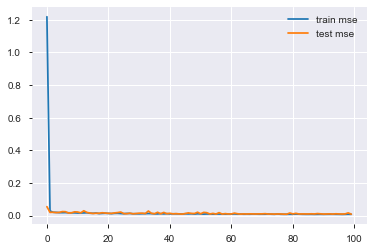

In [407]:
#結果の表示
import matplotlib.pyplot as plt #プロット用のライブラリを利用

print(model.evaluate(valid_X_nn, valid_y_nn))

train_acc = history.history['loss']
test_acc = history.history['val_loss']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'test mse')
plt.legend() #グラフの線の説明を表示

In [408]:
pred_y=model.predict(valid_X_nn)
score=mean_absolute_error(np.exp(valid_y_nn),np.exp(pred_y))
print(f'MAE:{score:4f}')
pred=model.predict(test_nn)


MAE:25.749117


,position,age,area,sex,partner,num_child,education,service_length,study_time,commute,overtime,familiy_num,agexposition,cluster
0,4,39,14,1,1,5,2,19,1.0,1.8,14.2,7,156.0,19
1,2,31,27,0,0,0,5,0,0.0,0.5,18.6,1,62.0,0
2,1,20,45,1,1,2,1,2,2.0,1.2,2.3,4,30.0,14
3,1,28,37,1,0,0,1,10,3.0,0.3,0.0,1,42.0,9
4,2,41,16,1,0,0,1,23,3.0,0.5,10.1,1,82.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,2,43,14,1,0,0,1,25,3.0,0.7,0.0,1,86.0,4
8996,3,40,5,1,0,0,1,22,8.0,0.7,5.7,1,120.0,7
8997,5,46,24,0,0,0,1,28,2.0,0.8,0.0,1,230.0,17
8998,1,22,13,0,0,0,1,4,0.0,0.1,0.7,1,33.0,12


# Stacking

In [512]:
import numpy as np
import pandas as pd
from catboost import CatBoost
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
# tensorflowの警告抑制
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# ---------------------------------
# データ等の準備
# ----------------------------------
import numpy as np
import pandas as pd


# ---------------------------------
# スタッキング
# ----------------------------------
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

# models.pyにModel1Xgb, Model1NN, Model2Linearを定義しているものとする
# 各クラスは、fitで学習し、predictで予測値の確率を出力する


# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test


# 1層目のモデル

model_1a =xgb.XGBRegressor(**{'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06})
pred_train_1a, pred_test_1a = predict_cv(model_1a, X, y, test)

model_1b = lgb.LGBMRegressor(**{ 'depth': 22, 'learning_rate': 0.15022735769525583, 'random_strength': 40, 'bagging_temperature': 0.03207087240546606, 'od_type': 'Iter', 'od_wait': 41})
pred_train_1b, pred_test_1b = predict_cv(model_1b, X, y, test)

model_1c = LGBRegressorCV(n_trials=10)
pred_train_1c, pred_test_1c = predict_cv(model_1c, X, y, test)

model_1d = RFRegressorCV(n_trials=10)
pred_train_1d, pred_test_1d = predict_cv(model_1d, X, y, test)

model_1e= CatBoost({'learning_rate': 0.17321274085322982, 'random_strength': 94, 'bagging_temperature': 0.2804904005490844, 'od_type': 'IncToDec', 'od_wait': 50})
pred_train_1e, pred_test_1e = predict_cv(model_1e, X, y, test)


# 1層目のモデルの評価
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1a))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1b))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1c))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1d))}')
print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_1e))}')

# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b,'pred_1c': pred_train_1c,'pred_1d': pred_train_1d,'pred_1e': pred_train_1e})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b, 'pred_1c': pred_test_1c, 'pred_1d': pred_test_1d, 'pred_1e': pred_test_1e})


# 2層目のモデル
# pred_train_2は、2層目のモデルの学習データのクロスバリデーションでの予測値
# pred_test_2は、2層目のモデルのテストデータの予測値
model_2 = XGBRegressorCV(n_trials=20)
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, y, test_x_2)

print(f'logloss: {mean_absolute_error(np.exp(y),np.exp( pred_train_2))}')



[22:13:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:14:07,447] Finished trial#0 resulted in value: 0.9143755837764973. Current best value is 0.9143755837764973 with parameters: {'booster': 'gbtree', 'iterations': 135, 'learning_rate': 0.8151368878154551, 'random_strength': 94, 'bagging_temperature': 6.938280999202821, 'od_type': 'IncToDec', 'od_wait': 19, 'lambda_l1': 9.699582345379795e-08, 'lambda_l2': 0.0018368260823978786, 'num_leaves': 157, 'feature_fraction': 0.7664785013828086, 'bagging_fraction': 0.6302200992159606, 'bagging_freq': 4, 'min_child_samples': 49}.
[I 2019-11-20 22:14:09,217] Finished trial#1 resulted in value: 0.9546423755060085. Current best value is 0.9546423755060085 with parameters: {'booster': 'gblinear', 'iterations': 180, 'learning_rate': 0.16773953349424586, 'random_strength': 66, 'bagging_temperature': 0.027908674738595336, 'od_type': 'IncToDec', 'od_wait': 43, 'lambda_l1': 7.71987468312203e-07, 'lambda_l2': 1.5951076717793644, 'num_leaves': 53, 'feature_fraction': 0.497757371866325, 'baggin


Best score: 0.95
Best params: {'booster': 'gblinear', 'iterations': 180, 'learning_rate': 0.16773953349424586, 'random_strength': 66, 'bagging_temperature': 0.027908674738595336, 'od_type': 'IncToDec', 'od_wait': 43, 'lambda_l1': 7.71987468312203e-07, 'lambda_l2': 1.5951076717793644, 'num_leaves': 53, 'feature_fraction': 0.497757371866325, 'bagging_fraction': 0.7724507844007065, 'bagging_freq': 2, 'min_child_samples': 19}



[I 2019-11-20 22:14:33,823] Finished trial#0 resulted in value: 0.94704061569658. Current best value is 0.94704061569658 with parameters: {'booster': 'gblinear', 'iterations': 304, 'learning_rate': 0.04127893448549056, 'random_strength': 27, 'bagging_temperature': 50.328958880835046, 'od_type': 'IncToDec', 'od_wait': 40, 'lambda_l1': 0.4158578413536228, 'lambda_l2': 5.9115592804708186e-05, 'num_leaves': 225, 'feature_fraction': 0.5035461792628737, 'bagging_fraction': 0.6952287675309226, 'bagging_freq': 4, 'min_child_samples': 15}.
[I 2019-11-20 22:14:36,576] Finished trial#1 resulted in value: 0.9550118655159926. Current best value is 0.9550118655159926 with parameters: {'booster': 'gbtree', 'iterations': 108, 'learning_rate': 0.15772881137717037, 'random_strength': 12, 'bagging_temperature': 0.013901216674422201, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.6349504363110887, 'lambda_l2': 1.7242187482734048e-05, 'num_leaves': 142, 'feature_fraction': 0.570213403089252, 'bagging_fra


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 108, 'learning_rate': 0.15772881137717037, 'random_strength': 12, 'bagging_temperature': 0.013901216674422201, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.6349504363110887, 'lambda_l2': 1.7242187482734048e-05, 'num_leaves': 142, 'feature_fraction': 0.570213403089252, 'bagging_fraction': 0.7007043967450461, 'bagging_freq': 6, 'min_child_samples': 8}



[I 2019-11-20 22:14:59,041] Finished trial#0 resulted in value: 0.9504733069802713. Current best value is 0.9504733069802713 with parameters: {'booster': 'gblinear', 'iterations': 143, 'learning_rate': 0.03353529918819856, 'random_strength': 62, 'bagging_temperature': 4.87860425405438, 'od_type': 'Iter', 'od_wait': 42, 'lambda_l1': 0.04308223230888693, 'lambda_l2': 6.975506696146087e-07, 'num_leaves': 155, 'feature_fraction': 0.784836886731884, 'bagging_fraction': 0.5882181838758687, 'bagging_freq': 7, 'min_child_samples': 12}.
[I 2019-11-20 22:15:01,522] Finished trial#1 resulted in value: 0.9540602696564477. Current best value is 0.9540602696564477 with parameters: {'booster': 'gbtree', 'iterations': 341, 'learning_rate': 0.19637163428952623, 'random_strength': 2, 'bagging_temperature': 1.5407039413491679, 'od_type': 'Iter', 'od_wait': 17, 'lambda_l1': 0.0007873776598892658, 'lambda_l2': 1.1298379433824174e-08, 'num_leaves': 111, 'feature_fraction': 0.5065244612627627, 'bagging_fract


Best score: 0.95
Best params: {'booster': 'gbtree', 'iterations': 224, 'learning_rate': 0.09225612104697202, 'random_strength': 94, 'bagging_temperature': 0.2825900533936127, 'od_type': 'Iter', 'od_wait': 12, 'lambda_l1': 1.3143075638431384e-08, 'lambda_l2': 0.004300637156614743, 'num_leaves': 212, 'feature_fraction': 0.8557425015964467, 'bagging_fraction': 0.4723789103181295, 'bagging_freq': 1, 'min_child_samples': 39}



[I 2019-11-20 22:15:22,494] Finished trial#0 resulted in value: 0.9538188499877602. Current best value is 0.9538188499877602 with parameters: {'booster': 'gbtree', 'iterations': 133, 'learning_rate': 0.09890559191914468, 'random_strength': 32, 'bagging_temperature': 0.09663216383949942, 'od_type': 'IncToDec', 'od_wait': 19, 'lambda_l1': 0.1713769169194866, 'lambda_l2': 0.006942364511099813, 'num_leaves': 243, 'feature_fraction': 0.4974983173880728, 'bagging_fraction': 0.8145793724156651, 'bagging_freq': 4, 'min_child_samples': 41}.
[I 2019-11-20 22:15:24,833] Finished trial#1 resulted in value: 0.9565228410311374. Current best value is 0.9565228410311374 with parameters: {'booster': 'gbtree', 'iterations': 201, 'learning_rate': 0.10026616749630636, 'random_strength': 99, 'bagging_temperature': 43.751518096315124, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.0033900493889292968, 'lambda_l2': 0.40925196088280513, 'num_leaves': 87, 'feature_fraction': 0.5121846411931855, 'bagging_frac


Best score: 0.96
Best params: {'booster': 'gbtree', 'iterations': 201, 'learning_rate': 0.10026616749630636, 'random_strength': 99, 'bagging_temperature': 43.751518096315124, 'od_type': 'Iter', 'od_wait': 15, 'lambda_l1': 0.0033900493889292968, 'lambda_l2': 0.40925196088280513, 'num_leaves': 87, 'feature_fraction': 0.5121846411931855, 'bagging_fraction': 0.8977678637442313, 'bagging_freq': 5, 'min_child_samples': 31}



[I 2019-11-20 22:15:47,479] Finished trial#0 resulted in value: 0.9098631337997892. Current best value is 0.9098631337997892 with parameters: {'n_estimators': 11, 'max_features': 2, 'min_samples_split': 19, 'max_depth': 63}.
[I 2019-11-20 22:15:49,810] Finished trial#1 resulted in value: 0.9016829986684515. Current best value is 0.9098631337997892 with parameters: {'n_estimators': 11, 'max_features': 2, 'min_samples_split': 19, 'max_depth': 63}.
[I 2019-11-20 22:16:02,288] Finished trial#2 resulted in value: 0.9384689135926493. Current best value is 0.9384689135926493 with parameters: {'n_estimators': 138, 'max_features': 8, 'min_samples_split': 92, 'max_depth': 87}.
[I 2019-11-20 22:16:03,701] Finished trial#3 resulted in value: 0.9313762053722648. Current best value is 0.9384689135926493 with parameters: {'n_estimators': 138, 'max_features': 8, 'min_samples_split': 92, 'max_depth': 87}.
[I 2019-11-20 22:16:13,944] Finished trial#4 resulted in value: 0.9376281643115604. Current best v


Best score: 0.95
Best params: {'n_estimators': 155, 'max_features': 6, 'min_samples_split': 30, 'max_depth': 15}



[I 2019-11-20 22:17:45,807] Finished trial#0 resulted in value: 0.9452188807883987. Current best value is 0.9452188807883987 with parameters: {'n_estimators': 126, 'max_features': 13, 'min_samples_split': 69, 'max_depth': 93}.
[I 2019-11-20 22:17:50,319] Finished trial#1 resulted in value: 0.9432082420632095. Current best value is 0.9452188807883987 with parameters: {'n_estimators': 126, 'max_features': 13, 'min_samples_split': 69, 'max_depth': 93}.
[I 2019-11-20 22:17:52,131] Finished trial#2 resulted in value: 0.8996349622102139. Current best value is 0.9452188807883987 with parameters: {'n_estimators': 126, 'max_features': 13, 'min_samples_split': 69, 'max_depth': 93}.
[I 2019-11-20 22:20:16,849] Finished trial#3 resulted in value: 0.9551288903639952. Current best value is 0.9551288903639952 with parameters: {'n_estimators': 163, 'max_features': 12, 'min_samples_split': 20, 'max_depth': 48}.
[I 2019-11-20 22:20:26,844] Finished trial#4 resulted in value: 0.9436628402990099. Current 


Best score: 0.96
Best params: {'n_estimators': 130, 'max_features': 10, 'min_samples_split': 9, 'max_depth': 76}



[I 2019-11-20 22:21:32,640] Finished trial#0 resulted in value: 0.9469273275509188. Current best value is 0.9469273275509188 with parameters: {'n_estimators': 190, 'max_features': 8, 'min_samples_split': 60, 'max_depth': 64}.
[I 2019-11-20 22:21:55,774] Finished trial#1 resulted in value: 0.9549629412847797. Current best value is 0.9549629412847797 with parameters: {'n_estimators': 193, 'max_features': 7, 'min_samples_split': 12, 'max_depth': 90}.
[I 2019-11-20 22:21:58,252] Finished trial#2 resulted in value: 0.8347125462202161. Current best value is 0.9549629412847797 with parameters: {'n_estimators': 193, 'max_features': 7, 'min_samples_split': 12, 'max_depth': 90}.
[I 2019-11-20 22:22:07,220] Finished trial#3 resulted in value: 0.9453861622215122. Current best value is 0.9549629412847797 with parameters: {'n_estimators': 193, 'max_features': 7, 'min_samples_split': 12, 'max_depth': 90}.
[I 2019-11-20 22:22:25,398] Finished trial#4 resulted in value: 0.9542778205098813. Current best


Best score: 0.96
Best params: {'n_estimators': 114, 'max_features': 12, 'min_samples_split': 20, 'max_depth': 36}



[I 2019-11-20 22:23:23,078] Finished trial#0 resulted in value: 0.9162962515707646. Current best value is 0.9162962515707646 with parameters: {'n_estimators': 149, 'max_features': 2, 'min_samples_split': 22, 'max_depth': 82}.
[I 2019-11-20 22:23:27,407] Finished trial#1 resulted in value: 0.947898840167851. Current best value is 0.947898840167851 with parameters: {'n_estimators': 42, 'max_features': 4, 'min_samples_split': 8, 'max_depth': 92}.
[I 2019-11-20 22:23:33,804] Finished trial#2 resulted in value: 0.9038808555600181. Current best value is 0.947898840167851 with parameters: {'n_estimators': 42, 'max_features': 4, 'min_samples_split': 8, 'max_depth': 92}.
[I 2019-11-20 22:23:46,423] Finished trial#3 resulted in value: 0.9469090226830715. Current best value is 0.947898840167851 with parameters: {'n_estimators': 42, 'max_features': 4, 'min_samples_split': 8, 'max_depth': 92}.
[I 2019-11-20 22:24:00,608] Finished trial#4 resulted in value: 0.9479277915431471. Current best value is 


Best score: 0.96
Best params: {'n_estimators': 160, 'max_features': 11, 'min_samples_split': 7, 'max_depth': 70}

0:	learn: 0.4007749	total: 4.7ms	remaining: 4.69s
1:	learn: 0.3628360	total: 12.3ms	remaining: 6.12s
2:	learn: 0.3355615	total: 23ms	remaining: 7.65s
3:	learn: 0.3116683	total: 36.1ms	remaining: 9s
4:	learn: 0.2928513	total: 67.3ms	remaining: 13.4s
5:	learn: 0.2788128	total: 80.8ms	remaining: 13.4s
6:	learn: 0.2651759	total: 112ms	remaining: 15.8s
7:	learn: 0.2569273	total: 119ms	remaining: 14.7s
8:	learn: 0.2461002	total: 127ms	remaining: 13.9s
9:	learn: 0.2340684	total: 139ms	remaining: 13.8s
10:	learn: 0.2220914	total: 160ms	remaining: 14.4s
11:	learn: 0.2161497	total: 170ms	remaining: 14s
12:	learn: 0.2095868	total: 181ms	remaining: 13.7s
13:	learn: 0.2050956	total: 213ms	remaining: 15s
14:	learn: 0.2022421	total: 238ms	remaining: 15.6s
15:	learn: 0.1991205	total: 259ms	remaining: 15.9s
16:	learn: 0.1959589	total: 286ms	remaining: 16.5s
17:	learn: 0.1921920	total: 300m

159:	learn: 0.0915319	total: 1.83s	remaining: 9.59s
160:	learn: 0.0914265	total: 1.84s	remaining: 9.58s
161:	learn: 0.0913063	total: 1.85s	remaining: 9.55s
162:	learn: 0.0912392	total: 1.85s	remaining: 9.52s
163:	learn: 0.0911143	total: 1.86s	remaining: 9.51s
164:	learn: 0.0910040	total: 1.87s	remaining: 9.48s
165:	learn: 0.0909483	total: 1.88s	remaining: 9.45s
166:	learn: 0.0908742	total: 1.89s	remaining: 9.43s
167:	learn: 0.0908231	total: 1.9s	remaining: 9.41s
168:	learn: 0.0906985	total: 1.91s	remaining: 9.4s
169:	learn: 0.0906550	total: 1.92s	remaining: 9.39s
170:	learn: 0.0905911	total: 1.93s	remaining: 9.36s
171:	learn: 0.0905172	total: 1.94s	remaining: 9.35s
172:	learn: 0.0904518	total: 1.95s	remaining: 9.34s
173:	learn: 0.0903354	total: 1.96s	remaining: 9.31s
174:	learn: 0.0900922	total: 1.97s	remaining: 9.3s
175:	learn: 0.0900091	total: 1.99s	remaining: 9.29s
176:	learn: 0.0898601	total: 2s	remaining: 9.28s
177:	learn: 0.0897850	total: 2s	remaining: 9.26s
178:	learn: 0.0897004

318:	learn: 0.0808243	total: 3.58s	remaining: 7.65s
319:	learn: 0.0807595	total: 3.59s	remaining: 7.63s
320:	learn: 0.0806970	total: 3.6s	remaining: 7.62s
321:	learn: 0.0806563	total: 3.61s	remaining: 7.61s
322:	learn: 0.0806247	total: 3.62s	remaining: 7.59s
323:	learn: 0.0805453	total: 3.63s	remaining: 7.58s
324:	learn: 0.0805317	total: 3.64s	remaining: 7.56s
325:	learn: 0.0804885	total: 3.65s	remaining: 7.54s
326:	learn: 0.0804648	total: 3.66s	remaining: 7.53s
327:	learn: 0.0804315	total: 3.67s	remaining: 7.52s
328:	learn: 0.0804022	total: 3.68s	remaining: 7.5s
329:	learn: 0.0803584	total: 3.69s	remaining: 7.49s
330:	learn: 0.0803366	total: 3.7s	remaining: 7.48s
331:	learn: 0.0802961	total: 3.71s	remaining: 7.46s
332:	learn: 0.0802667	total: 3.72s	remaining: 7.45s
333:	learn: 0.0802341	total: 3.73s	remaining: 7.44s
334:	learn: 0.0801569	total: 3.74s	remaining: 7.43s
335:	learn: 0.0801295	total: 3.75s	remaining: 7.42s
336:	learn: 0.0800770	total: 3.77s	remaining: 7.41s
337:	learn: 0.0

477:	learn: 0.0752524	total: 5.26s	remaining: 5.75s
478:	learn: 0.0752150	total: 5.27s	remaining: 5.74s
479:	learn: 0.0751810	total: 5.28s	remaining: 5.72s
480:	learn: 0.0751662	total: 5.29s	remaining: 5.71s
481:	learn: 0.0751355	total: 5.3s	remaining: 5.69s
482:	learn: 0.0751002	total: 5.31s	remaining: 5.68s
483:	learn: 0.0750820	total: 5.32s	remaining: 5.67s
484:	learn: 0.0750548	total: 5.33s	remaining: 5.66s
485:	learn: 0.0750350	total: 5.34s	remaining: 5.65s
486:	learn: 0.0750071	total: 5.35s	remaining: 5.64s
487:	learn: 0.0749921	total: 5.36s	remaining: 5.63s
488:	learn: 0.0749542	total: 5.38s	remaining: 5.62s
489:	learn: 0.0749331	total: 5.39s	remaining: 5.61s
490:	learn: 0.0749261	total: 5.4s	remaining: 5.59s
491:	learn: 0.0749011	total: 5.41s	remaining: 5.58s
492:	learn: 0.0748674	total: 5.42s	remaining: 5.57s
493:	learn: 0.0748506	total: 5.43s	remaining: 5.56s
494:	learn: 0.0748209	total: 5.44s	remaining: 5.55s
495:	learn: 0.0748085	total: 5.45s	remaining: 5.54s
496:	learn: 0.

636:	learn: 0.0715199	total: 6.89s	remaining: 3.93s
637:	learn: 0.0715122	total: 6.9s	remaining: 3.91s
638:	learn: 0.0714770	total: 6.91s	remaining: 3.9s
639:	learn: 0.0714666	total: 6.92s	remaining: 3.89s
640:	learn: 0.0714524	total: 6.92s	remaining: 3.88s
641:	learn: 0.0714275	total: 6.93s	remaining: 3.87s
642:	learn: 0.0714079	total: 6.94s	remaining: 3.85s
643:	learn: 0.0713614	total: 6.95s	remaining: 3.84s
644:	learn: 0.0713371	total: 6.96s	remaining: 3.83s
645:	learn: 0.0713179	total: 6.97s	remaining: 3.82s
646:	learn: 0.0713077	total: 6.98s	remaining: 3.81s
647:	learn: 0.0712988	total: 7s	remaining: 3.8s
648:	learn: 0.0712723	total: 7.01s	remaining: 3.79s
649:	learn: 0.0712580	total: 7.02s	remaining: 3.78s
650:	learn: 0.0712440	total: 7.03s	remaining: 3.77s
651:	learn: 0.0712278	total: 7.04s	remaining: 3.76s
652:	learn: 0.0712059	total: 7.05s	remaining: 3.75s
653:	learn: 0.0711851	total: 7.06s	remaining: 3.73s
654:	learn: 0.0711546	total: 7.07s	remaining: 3.72s
655:	learn: 0.0711

795:	learn: 0.0683351	total: 8.54s	remaining: 2.19s
796:	learn: 0.0683107	total: 8.55s	remaining: 2.18s
797:	learn: 0.0682957	total: 8.56s	remaining: 2.17s
798:	learn: 0.0682756	total: 8.57s	remaining: 2.15s
799:	learn: 0.0682584	total: 8.57s	remaining: 2.14s
800:	learn: 0.0682353	total: 8.58s	remaining: 2.13s
801:	learn: 0.0682233	total: 8.59s	remaining: 2.12s
802:	learn: 0.0682085	total: 8.6s	remaining: 2.11s
803:	learn: 0.0682005	total: 8.61s	remaining: 2.1s
804:	learn: 0.0681869	total: 8.62s	remaining: 2.09s
805:	learn: 0.0681762	total: 8.63s	remaining: 2.08s
806:	learn: 0.0681540	total: 8.64s	remaining: 2.07s
807:	learn: 0.0681377	total: 8.65s	remaining: 2.06s
808:	learn: 0.0681242	total: 8.66s	remaining: 2.04s
809:	learn: 0.0681063	total: 8.67s	remaining: 2.03s
810:	learn: 0.0680958	total: 8.68s	remaining: 2.02s
811:	learn: 0.0680769	total: 8.69s	remaining: 2.01s
812:	learn: 0.0680622	total: 8.7s	remaining: 2s
813:	learn: 0.0680445	total: 8.71s	remaining: 1.99s
814:	learn: 0.0680

954:	learn: 0.0656079	total: 10.1s	remaining: 477ms
955:	learn: 0.0655808	total: 10.1s	remaining: 467ms
956:	learn: 0.0655626	total: 10.2s	remaining: 456ms
957:	learn: 0.0655565	total: 10.2s	remaining: 445ms
958:	learn: 0.0655424	total: 10.2s	remaining: 435ms
959:	learn: 0.0655356	total: 10.2s	remaining: 424ms
960:	learn: 0.0655253	total: 10.2s	remaining: 414ms
961:	learn: 0.0655145	total: 10.2s	remaining: 404ms
962:	learn: 0.0654923	total: 10.3s	remaining: 394ms
963:	learn: 0.0654728	total: 10.3s	remaining: 384ms
964:	learn: 0.0654656	total: 10.3s	remaining: 373ms
965:	learn: 0.0654509	total: 10.3s	remaining: 363ms
966:	learn: 0.0654410	total: 10.3s	remaining: 352ms
967:	learn: 0.0654226	total: 10.3s	remaining: 341ms
968:	learn: 0.0653974	total: 10.3s	remaining: 331ms
969:	learn: 0.0653756	total: 10.3s	remaining: 320ms
970:	learn: 0.0653589	total: 10.4s	remaining: 309ms
971:	learn: 0.0653433	total: 10.4s	remaining: 299ms
972:	learn: 0.0653235	total: 10.4s	remaining: 288ms
973:	learn: 

114:	learn: 0.0993173	total: 1.29s	remaining: 9.94s
115:	learn: 0.0991173	total: 1.3s	remaining: 9.91s
116:	learn: 0.0986166	total: 1.31s	remaining: 9.87s
117:	learn: 0.0983636	total: 1.32s	remaining: 9.85s
118:	learn: 0.0982223	total: 1.33s	remaining: 9.84s
119:	learn: 0.0980736	total: 1.34s	remaining: 9.8s
120:	learn: 0.0978674	total: 1.34s	remaining: 9.77s
121:	learn: 0.0973507	total: 1.35s	remaining: 9.75s
122:	learn: 0.0971902	total: 1.37s	remaining: 9.75s
123:	learn: 0.0970613	total: 1.38s	remaining: 9.72s
124:	learn: 0.0968319	total: 1.39s	remaining: 9.71s
125:	learn: 0.0966445	total: 1.4s	remaining: 9.69s
126:	learn: 0.0964411	total: 1.41s	remaining: 9.68s
127:	learn: 0.0963119	total: 1.42s	remaining: 9.67s
128:	learn: 0.0961182	total: 1.43s	remaining: 9.66s
129:	learn: 0.0958501	total: 1.44s	remaining: 9.63s
130:	learn: 0.0956422	total: 1.46s	remaining: 9.7s
131:	learn: 0.0954858	total: 1.48s	remaining: 9.76s
132:	learn: 0.0953529	total: 1.51s	remaining: 9.87s
133:	learn: 0.09

273:	learn: 0.0833713	total: 3.05s	remaining: 8.07s
274:	learn: 0.0833453	total: 3.06s	remaining: 8.07s
275:	learn: 0.0831859	total: 3.07s	remaining: 8.05s
276:	learn: 0.0831532	total: 3.08s	remaining: 8.04s
277:	learn: 0.0830966	total: 3.09s	remaining: 8.02s
278:	learn: 0.0830595	total: 3.1s	remaining: 8.02s
279:	learn: 0.0830081	total: 3.11s	remaining: 8.01s
280:	learn: 0.0829784	total: 3.12s	remaining: 8s
281:	learn: 0.0829440	total: 3.13s	remaining: 7.98s
282:	learn: 0.0829220	total: 3.15s	remaining: 7.97s
283:	learn: 0.0828422	total: 3.16s	remaining: 7.96s
284:	learn: 0.0827873	total: 3.17s	remaining: 7.95s
285:	learn: 0.0827108	total: 3.18s	remaining: 7.93s
286:	learn: 0.0826668	total: 3.19s	remaining: 7.93s
287:	learn: 0.0826120	total: 3.2s	remaining: 7.92s
288:	learn: 0.0825289	total: 3.21s	remaining: 7.9s
289:	learn: 0.0824596	total: 3.22s	remaining: 7.89s
290:	learn: 0.0824199	total: 3.23s	remaining: 7.88s
291:	learn: 0.0823666	total: 3.24s	remaining: 7.87s
292:	learn: 0.0822

432:	learn: 0.0769221	total: 4.76s	remaining: 6.24s
433:	learn: 0.0769035	total: 4.77s	remaining: 6.22s
434:	learn: 0.0768741	total: 4.78s	remaining: 6.21s
435:	learn: 0.0768318	total: 4.79s	remaining: 6.2s
436:	learn: 0.0767956	total: 4.8s	remaining: 6.18s
437:	learn: 0.0767384	total: 4.81s	remaining: 6.17s
438:	learn: 0.0767098	total: 4.82s	remaining: 6.15s
439:	learn: 0.0766955	total: 4.83s	remaining: 6.14s
440:	learn: 0.0766691	total: 4.84s	remaining: 6.13s
441:	learn: 0.0766415	total: 4.85s	remaining: 6.12s
442:	learn: 0.0766095	total: 4.86s	remaining: 6.11s
443:	learn: 0.0765922	total: 4.87s	remaining: 6.09s
444:	learn: 0.0765671	total: 4.88s	remaining: 6.08s
445:	learn: 0.0764755	total: 4.88s	remaining: 6.07s
446:	learn: 0.0764595	total: 4.89s	remaining: 6.05s
447:	learn: 0.0764157	total: 4.91s	remaining: 6.04s
448:	learn: 0.0763895	total: 4.91s	remaining: 6.03s
449:	learn: 0.0763698	total: 4.93s	remaining: 6.02s
450:	learn: 0.0763454	total: 4.94s	remaining: 6.01s
451:	learn: 0.

591:	learn: 0.0728460	total: 6.46s	remaining: 4.45s
592:	learn: 0.0728380	total: 6.47s	remaining: 4.44s
593:	learn: 0.0728223	total: 6.48s	remaining: 4.43s
594:	learn: 0.0727968	total: 6.49s	remaining: 4.42s
595:	learn: 0.0727778	total: 6.5s	remaining: 4.4s
596:	learn: 0.0727518	total: 6.5s	remaining: 4.39s
597:	learn: 0.0727227	total: 6.54s	remaining: 4.4s
598:	learn: 0.0727031	total: 6.59s	remaining: 4.41s
599:	learn: 0.0726672	total: 6.64s	remaining: 4.42s
600:	learn: 0.0726544	total: 6.67s	remaining: 4.43s
601:	learn: 0.0726451	total: 6.69s	remaining: 4.42s
602:	learn: 0.0726322	total: 6.71s	remaining: 4.41s
603:	learn: 0.0726158	total: 6.71s	remaining: 4.4s
604:	learn: 0.0725722	total: 6.73s	remaining: 4.39s
605:	learn: 0.0725505	total: 6.73s	remaining: 4.38s
606:	learn: 0.0725351	total: 6.75s	remaining: 4.37s
607:	learn: 0.0725183	total: 6.76s	remaining: 4.36s
608:	learn: 0.0724869	total: 6.77s	remaining: 4.35s
609:	learn: 0.0724686	total: 6.78s	remaining: 4.34s
610:	learn: 0.072

750:	learn: 0.0695090	total: 8.6s	remaining: 2.85s
751:	learn: 0.0694950	total: 8.61s	remaining: 2.84s
752:	learn: 0.0694835	total: 8.62s	remaining: 2.83s
753:	learn: 0.0694486	total: 8.63s	remaining: 2.82s
754:	learn: 0.0694441	total: 8.65s	remaining: 2.81s
755:	learn: 0.0694298	total: 8.67s	remaining: 2.8s
756:	learn: 0.0693957	total: 8.7s	remaining: 2.79s
757:	learn: 0.0693836	total: 8.72s	remaining: 2.79s
758:	learn: 0.0693610	total: 8.75s	remaining: 2.78s
759:	learn: 0.0693493	total: 8.77s	remaining: 2.77s
760:	learn: 0.0693388	total: 8.78s	remaining: 2.75s
761:	learn: 0.0693274	total: 8.79s	remaining: 2.75s
762:	learn: 0.0693122	total: 8.8s	remaining: 2.73s
763:	learn: 0.0692898	total: 8.82s	remaining: 2.72s
764:	learn: 0.0692807	total: 8.84s	remaining: 2.71s
765:	learn: 0.0692694	total: 8.85s	remaining: 2.7s
766:	learn: 0.0692561	total: 8.86s	remaining: 2.69s
767:	learn: 0.0692364	total: 8.87s	remaining: 2.68s
768:	learn: 0.0692278	total: 8.88s	remaining: 2.67s
769:	learn: 0.069

909:	learn: 0.0667211	total: 10.9s	remaining: 1.07s
910:	learn: 0.0666991	total: 10.9s	remaining: 1.06s
911:	learn: 0.0666894	total: 10.9s	remaining: 1.05s
912:	learn: 0.0666840	total: 10.9s	remaining: 1.04s
913:	learn: 0.0666654	total: 10.9s	remaining: 1.02s
914:	learn: 0.0666344	total: 10.9s	remaining: 1.01s
915:	learn: 0.0666169	total: 10.9s	remaining: 1s
916:	learn: 0.0665926	total: 10.9s	remaining: 990ms
917:	learn: 0.0665829	total: 11s	remaining: 978ms
918:	learn: 0.0665592	total: 11s	remaining: 967ms
919:	learn: 0.0665488	total: 11s	remaining: 955ms
920:	learn: 0.0665278	total: 11s	remaining: 943ms
921:	learn: 0.0665183	total: 11s	remaining: 931ms
922:	learn: 0.0665082	total: 11s	remaining: 919ms
923:	learn: 0.0664967	total: 11s	remaining: 907ms
924:	learn: 0.0664825	total: 11s	remaining: 895ms
925:	learn: 0.0664600	total: 11.1s	remaining: 884ms
926:	learn: 0.0664373	total: 11.1s	remaining: 872ms
927:	learn: 0.0664264	total: 11.1s	remaining: 861ms
928:	learn: 0.0664168	total: 11

69:	learn: 0.1398506	total: 959ms	remaining: 12.7s
70:	learn: 0.1363405	total: 968ms	remaining: 12.7s
71:	learn: 0.1357639	total: 983ms	remaining: 12.7s
72:	learn: 0.1333160	total: 995ms	remaining: 12.6s
73:	learn: 0.1323531	total: 1s	remaining: 12.6s
74:	learn: 0.1297694	total: 1.01s	remaining: 12.5s
75:	learn: 0.1282096	total: 1.02s	remaining: 12.4s
76:	learn: 0.1271614	total: 1.04s	remaining: 12.4s
77:	learn: 0.1252990	total: 1.05s	remaining: 12.4s
78:	learn: 0.1228615	total: 1.06s	remaining: 12.3s
79:	learn: 0.1218948	total: 1.07s	remaining: 12.3s
80:	learn: 0.1199620	total: 1.08s	remaining: 12.2s
81:	learn: 0.1184282	total: 1.09s	remaining: 12.2s
82:	learn: 0.1176578	total: 1.1s	remaining: 12.1s
83:	learn: 0.1165270	total: 1.11s	remaining: 12.1s
84:	learn: 0.1145732	total: 1.12s	remaining: 12s
85:	learn: 0.1131463	total: 1.13s	remaining: 12s
86:	learn: 0.1125889	total: 1.14s	remaining: 12s
87:	learn: 0.1117875	total: 1.15s	remaining: 12s
88:	learn: 0.1110293	total: 1.16s	remaining

228:	learn: 0.0845222	total: 2.82s	remaining: 9.49s
229:	learn: 0.0844744	total: 2.83s	remaining: 9.47s
230:	learn: 0.0844019	total: 2.84s	remaining: 9.45s
231:	learn: 0.0843882	total: 2.85s	remaining: 9.42s
232:	learn: 0.0843162	total: 2.85s	remaining: 9.4s
233:	learn: 0.0842188	total: 2.86s	remaining: 9.38s
234:	learn: 0.0841689	total: 2.88s	remaining: 9.37s
235:	learn: 0.0841119	total: 2.89s	remaining: 9.35s
236:	learn: 0.0840761	total: 2.9s	remaining: 9.33s
237:	learn: 0.0840369	total: 2.91s	remaining: 9.31s
238:	learn: 0.0839741	total: 2.92s	remaining: 9.3s
239:	learn: 0.0838935	total: 2.93s	remaining: 9.28s
240:	learn: 0.0838221	total: 2.94s	remaining: 9.26s
241:	learn: 0.0837810	total: 2.95s	remaining: 9.23s
242:	learn: 0.0837404	total: 2.96s	remaining: 9.22s
243:	learn: 0.0837019	total: 2.97s	remaining: 9.2s
244:	learn: 0.0836590	total: 2.98s	remaining: 9.18s
245:	learn: 0.0836268	total: 2.99s	remaining: 9.16s
246:	learn: 0.0835515	total: 3s	remaining: 9.13s
247:	learn: 0.08339

387:	learn: 0.0773069	total: 4.44s	remaining: 7.01s
388:	learn: 0.0772739	total: 4.45s	remaining: 6.99s
389:	learn: 0.0772468	total: 4.46s	remaining: 6.97s
390:	learn: 0.0772144	total: 4.47s	remaining: 6.96s
391:	learn: 0.0771748	total: 4.48s	remaining: 6.95s
392:	learn: 0.0771397	total: 4.49s	remaining: 6.93s
393:	learn: 0.0771066	total: 4.5s	remaining: 6.91s
394:	learn: 0.0770717	total: 4.51s	remaining: 6.9s
395:	learn: 0.0770574	total: 4.52s	remaining: 6.89s
396:	learn: 0.0770294	total: 4.52s	remaining: 6.87s
397:	learn: 0.0770084	total: 4.54s	remaining: 6.86s
398:	learn: 0.0769933	total: 4.54s	remaining: 6.84s
399:	learn: 0.0769443	total: 4.55s	remaining: 6.83s
400:	learn: 0.0769020	total: 4.57s	remaining: 6.82s
401:	learn: 0.0768703	total: 4.58s	remaining: 6.8s
402:	learn: 0.0768487	total: 4.59s	remaining: 6.79s
403:	learn: 0.0767351	total: 4.62s	remaining: 6.82s
404:	learn: 0.0767053	total: 4.64s	remaining: 6.82s
405:	learn: 0.0766777	total: 4.66s	remaining: 6.82s
406:	learn: 0.0

546:	learn: 0.0727851	total: 6.26s	remaining: 5.18s
547:	learn: 0.0727619	total: 6.27s	remaining: 5.17s
548:	learn: 0.0727467	total: 6.28s	remaining: 5.16s
549:	learn: 0.0727281	total: 6.29s	remaining: 5.15s
550:	learn: 0.0727085	total: 6.3s	remaining: 5.13s
551:	learn: 0.0726728	total: 6.31s	remaining: 5.12s
552:	learn: 0.0726466	total: 6.32s	remaining: 5.11s
553:	learn: 0.0726158	total: 6.34s	remaining: 5.1s
554:	learn: 0.0725953	total: 6.35s	remaining: 5.09s
555:	learn: 0.0725719	total: 6.36s	remaining: 5.08s
556:	learn: 0.0725366	total: 6.37s	remaining: 5.07s
557:	learn: 0.0725122	total: 6.38s	remaining: 5.05s
558:	learn: 0.0724920	total: 6.39s	remaining: 5.04s
559:	learn: 0.0724692	total: 6.4s	remaining: 5.03s
560:	learn: 0.0724517	total: 6.41s	remaining: 5.02s
561:	learn: 0.0724146	total: 6.42s	remaining: 5s
562:	learn: 0.0723679	total: 6.43s	remaining: 4.99s
563:	learn: 0.0723526	total: 6.44s	remaining: 4.98s
564:	learn: 0.0723319	total: 6.46s	remaining: 4.97s
565:	learn: 0.0723

705:	learn: 0.0692741	total: 8.25s	remaining: 3.44s
706:	learn: 0.0692677	total: 8.26s	remaining: 3.42s
707:	learn: 0.0692294	total: 8.27s	remaining: 3.41s
708:	learn: 0.0692030	total: 8.28s	remaining: 3.4s
709:	learn: 0.0691822	total: 8.29s	remaining: 3.39s
710:	learn: 0.0691734	total: 8.3s	remaining: 3.37s
711:	learn: 0.0691481	total: 8.31s	remaining: 3.36s
712:	learn: 0.0691265	total: 8.33s	remaining: 3.35s
713:	learn: 0.0691076	total: 8.34s	remaining: 3.34s
714:	learn: 0.0690791	total: 8.35s	remaining: 3.33s
715:	learn: 0.0690667	total: 8.36s	remaining: 3.32s
716:	learn: 0.0690320	total: 8.37s	remaining: 3.31s
717:	learn: 0.0690195	total: 8.38s	remaining: 3.29s
718:	learn: 0.0689989	total: 8.4s	remaining: 3.28s
719:	learn: 0.0689781	total: 8.41s	remaining: 3.27s
720:	learn: 0.0689666	total: 8.42s	remaining: 3.26s
721:	learn: 0.0689270	total: 8.43s	remaining: 3.25s
722:	learn: 0.0689027	total: 8.44s	remaining: 3.23s
723:	learn: 0.0688833	total: 8.45s	remaining: 3.22s
724:	learn: 0.0

864:	learn: 0.0663007	total: 10.3s	remaining: 1.6s
865:	learn: 0.0662862	total: 10.3s	remaining: 1.59s
866:	learn: 0.0662761	total: 10.3s	remaining: 1.58s
867:	learn: 0.0662597	total: 10.3s	remaining: 1.57s
868:	learn: 0.0662421	total: 10.3s	remaining: 1.55s
869:	learn: 0.0662172	total: 10.3s	remaining: 1.54s
870:	learn: 0.0661892	total: 10.3s	remaining: 1.53s
871:	learn: 0.0661755	total: 10.4s	remaining: 1.52s
872:	learn: 0.0661623	total: 10.4s	remaining: 1.51s
873:	learn: 0.0661366	total: 10.4s	remaining: 1.5s
874:	learn: 0.0661283	total: 10.4s	remaining: 1.48s
875:	learn: 0.0661194	total: 10.4s	remaining: 1.47s
876:	learn: 0.0661049	total: 10.4s	remaining: 1.46s
877:	learn: 0.0660849	total: 10.4s	remaining: 1.45s
878:	learn: 0.0660698	total: 10.4s	remaining: 1.44s
879:	learn: 0.0660541	total: 10.4s	remaining: 1.42s
880:	learn: 0.0660229	total: 10.5s	remaining: 1.41s
881:	learn: 0.0660070	total: 10.5s	remaining: 1.4s
882:	learn: 0.0659979	total: 10.5s	remaining: 1.39s
883:	learn: 0.0

23:	learn: 0.1775700	total: 284ms	remaining: 11.5s
24:	learn: 0.1700113	total: 293ms	remaining: 11.4s
25:	learn: 0.1690773	total: 311ms	remaining: 11.6s
26:	learn: 0.1688258	total: 326ms	remaining: 11.8s
27:	learn: 0.1684349	total: 336ms	remaining: 11.7s
28:	learn: 0.1678890	total: 353ms	remaining: 11.8s
29:	learn: 0.1677624	total: 362ms	remaining: 11.7s
30:	learn: 0.1674600	total: 376ms	remaining: 11.7s
31:	learn: 0.1671059	total: 387ms	remaining: 11.7s
32:	learn: 0.1670821	total: 400ms	remaining: 11.7s
33:	learn: 0.1669657	total: 408ms	remaining: 11.6s
34:	learn: 0.1666922	total: 421ms	remaining: 11.6s
35:	learn: 0.1663787	total: 430ms	remaining: 11.5s
36:	learn: 0.1658253	total: 444ms	remaining: 11.6s
37:	learn: 0.1653139	total: 455ms	remaining: 11.5s
38:	learn: 0.1645261	total: 466ms	remaining: 11.5s
39:	learn: 0.1643665	total: 477ms	remaining: 11.4s
40:	learn: 0.1642770	total: 496ms	remaining: 11.6s
41:	learn: 0.1638012	total: 509ms	remaining: 11.6s
42:	learn: 0.1637227	total: 521

183:	learn: 0.0884152	total: 2.29s	remaining: 10.1s
184:	learn: 0.0883303	total: 2.3s	remaining: 10.1s
185:	learn: 0.0882662	total: 2.3s	remaining: 10.1s
186:	learn: 0.0881796	total: 2.31s	remaining: 10.1s
187:	learn: 0.0880987	total: 2.32s	remaining: 10s
188:	learn: 0.0880300	total: 2.33s	remaining: 10s
189:	learn: 0.0879774	total: 2.35s	remaining: 10s
190:	learn: 0.0879146	total: 2.36s	remaining: 10s
191:	learn: 0.0878217	total: 2.37s	remaining: 9.99s
192:	learn: 0.0877591	total: 2.38s	remaining: 9.96s
193:	learn: 0.0876519	total: 2.39s	remaining: 9.94s
194:	learn: 0.0875871	total: 2.4s	remaining: 9.92s
195:	learn: 0.0875415	total: 2.42s	remaining: 9.93s
196:	learn: 0.0874452	total: 2.43s	remaining: 9.9s
197:	learn: 0.0873879	total: 2.44s	remaining: 9.89s
198:	learn: 0.0873249	total: 2.45s	remaining: 9.87s
199:	learn: 0.0872870	total: 2.46s	remaining: 9.85s
200:	learn: 0.0872084	total: 2.48s	remaining: 9.84s
201:	learn: 0.0871575	total: 2.49s	remaining: 9.82s
202:	learn: 0.0870628	to

342:	learn: 0.0795202	total: 4.15s	remaining: 7.95s
343:	learn: 0.0794672	total: 4.17s	remaining: 7.94s
344:	learn: 0.0794369	total: 4.18s	remaining: 7.93s
345:	learn: 0.0793965	total: 4.19s	remaining: 7.92s
346:	learn: 0.0793633	total: 4.2s	remaining: 7.91s
347:	learn: 0.0793408	total: 4.21s	remaining: 7.9s
348:	learn: 0.0792792	total: 4.23s	remaining: 7.88s
349:	learn: 0.0792514	total: 4.24s	remaining: 7.87s
350:	learn: 0.0792337	total: 4.25s	remaining: 7.85s
351:	learn: 0.0792146	total: 4.26s	remaining: 7.84s
352:	learn: 0.0791924	total: 4.27s	remaining: 7.83s
353:	learn: 0.0791488	total: 4.28s	remaining: 7.82s
354:	learn: 0.0791194	total: 4.29s	remaining: 7.8s
355:	learn: 0.0790848	total: 4.3s	remaining: 7.78s
356:	learn: 0.0790523	total: 4.31s	remaining: 7.77s
357:	learn: 0.0790330	total: 4.32s	remaining: 7.75s
358:	learn: 0.0789821	total: 4.34s	remaining: 7.74s
359:	learn: 0.0789609	total: 4.34s	remaining: 7.72s
360:	learn: 0.0789340	total: 4.36s	remaining: 7.71s
361:	learn: 0.07

501:	learn: 0.0744698	total: 6.01s	remaining: 5.96s
502:	learn: 0.0744584	total: 6.02s	remaining: 5.95s
503:	learn: 0.0744109	total: 6.03s	remaining: 5.93s
504:	learn: 0.0743749	total: 6.04s	remaining: 5.92s
505:	learn: 0.0743469	total: 6.05s	remaining: 5.91s
506:	learn: 0.0743282	total: 6.06s	remaining: 5.89s
507:	learn: 0.0742876	total: 6.07s	remaining: 5.88s
508:	learn: 0.0742371	total: 6.08s	remaining: 5.87s
509:	learn: 0.0742175	total: 6.09s	remaining: 5.86s
510:	learn: 0.0741979	total: 6.11s	remaining: 5.85s
511:	learn: 0.0741654	total: 6.12s	remaining: 5.84s
512:	learn: 0.0741383	total: 6.13s	remaining: 5.82s
513:	learn: 0.0741132	total: 6.14s	remaining: 5.81s
514:	learn: 0.0740981	total: 6.15s	remaining: 5.79s
515:	learn: 0.0740656	total: 6.17s	remaining: 5.79s
516:	learn: 0.0740379	total: 6.18s	remaining: 5.77s
517:	learn: 0.0739961	total: 6.19s	remaining: 5.76s
518:	learn: 0.0739789	total: 6.2s	remaining: 5.75s
519:	learn: 0.0739516	total: 6.21s	remaining: 5.73s
520:	learn: 0

660:	learn: 0.0706409	total: 7.81s	remaining: 4.01s
661:	learn: 0.0706211	total: 7.83s	remaining: 4s
662:	learn: 0.0705953	total: 7.84s	remaining: 3.98s
663:	learn: 0.0705653	total: 7.85s	remaining: 3.97s
664:	learn: 0.0705568	total: 7.87s	remaining: 3.96s
665:	learn: 0.0705306	total: 7.88s	remaining: 3.95s
666:	learn: 0.0705011	total: 7.9s	remaining: 3.94s
667:	learn: 0.0704702	total: 7.93s	remaining: 3.94s
668:	learn: 0.0704094	total: 7.95s	remaining: 3.94s
669:	learn: 0.0703831	total: 7.97s	remaining: 3.93s
670:	learn: 0.0703655	total: 7.98s	remaining: 3.91s
671:	learn: 0.0703396	total: 7.99s	remaining: 3.9s
672:	learn: 0.0703232	total: 8.01s	remaining: 3.89s
673:	learn: 0.0703120	total: 8.01s	remaining: 3.88s
674:	learn: 0.0702922	total: 8.03s	remaining: 3.86s
675:	learn: 0.0702840	total: 8.03s	remaining: 3.85s
676:	learn: 0.0702795	total: 8.04s	remaining: 3.84s
677:	learn: 0.0702664	total: 8.05s	remaining: 3.83s
678:	learn: 0.0702370	total: 8.06s	remaining: 3.81s
679:	learn: 0.070

819:	learn: 0.0675128	total: 9.78s	remaining: 2.15s
820:	learn: 0.0674932	total: 9.79s	remaining: 2.13s
821:	learn: 0.0674715	total: 9.8s	remaining: 2.12s
822:	learn: 0.0674616	total: 9.82s	remaining: 2.11s
823:	learn: 0.0674565	total: 9.83s	remaining: 2.1s
824:	learn: 0.0674347	total: 9.84s	remaining: 2.09s
825:	learn: 0.0674145	total: 9.85s	remaining: 2.07s
826:	learn: 0.0673909	total: 9.86s	remaining: 2.06s
827:	learn: 0.0673764	total: 9.88s	remaining: 2.05s
828:	learn: 0.0673611	total: 9.89s	remaining: 2.04s
829:	learn: 0.0673570	total: 9.9s	remaining: 2.03s
830:	learn: 0.0673329	total: 9.91s	remaining: 2.01s
831:	learn: 0.0673083	total: 9.92s	remaining: 2s
832:	learn: 0.0673016	total: 9.94s	remaining: 1.99s
833:	learn: 0.0672941	total: 9.96s	remaining: 1.98s
834:	learn: 0.0672796	total: 9.98s	remaining: 1.97s
835:	learn: 0.0672714	total: 10s	remaining: 1.96s
836:	learn: 0.0672619	total: 10s	remaining: 1.95s
837:	learn: 0.0672435	total: 10s	remaining: 1.94s
838:	learn: 0.0672207	to

978:	learn: 0.0647794	total: 11.6s	remaining: 249ms
979:	learn: 0.0647594	total: 11.6s	remaining: 237ms
980:	learn: 0.0647519	total: 11.6s	remaining: 225ms
981:	learn: 0.0647313	total: 11.6s	remaining: 213ms
982:	learn: 0.0647151	total: 11.6s	remaining: 201ms
983:	learn: 0.0647071	total: 11.7s	remaining: 190ms
984:	learn: 0.0646850	total: 11.7s	remaining: 178ms
985:	learn: 0.0646745	total: 11.7s	remaining: 166ms
986:	learn: 0.0646534	total: 11.7s	remaining: 154ms
987:	learn: 0.0646417	total: 11.7s	remaining: 142ms
988:	learn: 0.0646251	total: 11.7s	remaining: 130ms
989:	learn: 0.0646076	total: 11.7s	remaining: 118ms
990:	learn: 0.0645961	total: 11.7s	remaining: 107ms
991:	learn: 0.0645860	total: 11.7s	remaining: 94.7ms
992:	learn: 0.0645636	total: 11.8s	remaining: 82.9ms
993:	learn: 0.0645534	total: 11.8s	remaining: 71.1ms
994:	learn: 0.0645443	total: 11.8s	remaining: 59.2ms
995:	learn: 0.0645354	total: 11.8s	remaining: 47.4ms
996:	learn: 0.0645296	total: 11.8s	remaining: 35.5ms
997:	l

[I 2019-11-20 22:27:14,364] Finished trial#0 resulted in value: 0.959446554680546. Current best value is 0.959446554680546 with parameters: {'booster': 'dart', 'alpha': 5.467006519249799e-06, 'max_depth': 7, 'eta': 2.764853887455123e-06, 'gamma': 0.041725415619138694, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00041319581513775, 'skip_drop': 4.242086203304623e-08}.
[I 2019-11-20 22:27:30,046] Finished trial#1 resulted in value: 0.9592576372790826. Current best value is 0.959446554680546 with parameters: {'booster': 'dart', 'alpha': 5.467006519249799e-06, 'max_depth': 7, 'eta': 2.764853887455123e-06, 'gamma': 0.041725415619138694, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00041319581513775, 'skip_drop': 4.242086203304623e-08}.
[I 2019-11-20 22:27:35,145] Finished trial#2 resulted in value: 0.9594034175261603. Current best value is 0.959446554680546 with parameters: {'booster': 'dart'


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 0.011981318202155073, 'max_depth': 3, 'eta': 2.798499277899691e-07, 'gamma': 0.0019368421361087614, 'grow_policy': 'lossguide'}

[22:29:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:30:10,930] Finished trial#0 resulted in value: 0.9590365219205721. Current best value is 0.9590365219205721 with parameters: {'booster': 'dart', 'alpha': 0.001430622078659958, 'max_depth': 13, 'eta': 0.009894285469876826, 'gamma': 0.009612860606188885, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0026827799077475374, 'skip_drop': 0.16262302295105988}.
[I 2019-11-20 22:30:19,147] Finished trial#1 resulted in value: 0.9586482221954402. Current best value is 0.9590365219205721 with parameters: {'booster': 'dart', 'alpha': 0.001430622078659958, 'max_depth': 13, 'eta': 0.009894285469876826, 'gamma': 0.009612860606188885, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0026827799077475374, 'skip_drop': 0.16262302295105988}.
[I 2019-11-20 22:30:24,407] Finished trial#2 resulted in value: 0.9598497534308184. Current best value is 0.9598497534308184 with parameters: {'booster'


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 6.382305696486548e-06, 'max_depth': 3, 'eta': 7.984831578671018e-08, 'gamma': 5.864887871925556e-07, 'grow_policy': 'depthwise'}

[22:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:33:47,399] Finished trial#0 resulted in value: 0.960267257926034. Current best value is 0.960267257926034 with parameters: {'booster': 'gbtree', 'alpha': 0.021074193974668386, 'max_depth': 7, 'eta': 4.3417370643744257e-07, 'gamma': 2.3711580076315076e-06, 'grow_policy': 'lossguide'}.
[I 2019-11-20 22:34:03,854] Finished trial#1 resulted in value: 0.9602830236898179. Current best value is 0.9602830236898179 with parameters: {'booster': 'dart', 'alpha': 1.9516666353218994e-07, 'max_depth': 7, 'eta': 8.567099662061724e-08, 'gamma': 1.24745821431392e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.001968374477182454, 'skip_drop': 1.3039029776726324e-05}.
[I 2019-11-20 22:34:14,890] Finished trial#2 resulted in value: 0.9606384049387268. Current best value is 0.9606384049387268 with parameters: {'booster': 'dart', 'alpha': 3.1618269794700236e-08, 'max_depth': 4, 'eta': 4.212979746066548e-06, 'gamma': 3.4476828863126853e-07,


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 1.2580786434928108e-08, 'max_depth': 3, 'eta': 0.7478711536810951, 'gamma': 0.00012523166354540382, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.215671318760046e-08, 'skip_drop': 1.956571170605706e-06}

[22:38:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2019-11-20 22:38:19,708] Finished trial#0 resulted in value: 0.9594067788618149. Current best value is 0.9594067788618149 with parameters: {'booster': 'gbtree', 'alpha': 0.00027497183080624443, 'max_depth': 19, 'eta': 2.311844373497529e-07, 'gamma': 0.0026083639022135043, 'grow_policy': 'depthwise'}.
[I 2019-11-20 22:39:01,208] Finished trial#1 resulted in value: 0.9593873731670142. Current best value is 0.9594067788618149 with parameters: {'booster': 'gbtree', 'alpha': 0.00027497183080624443, 'max_depth': 19, 'eta': 2.311844373497529e-07, 'gamma': 0.0026083639022135043, 'grow_policy': 'depthwise'}.
[I 2019-11-20 22:39:16,321] Finished trial#2 resulted in value: 0.9590190433904571. Current best value is 0.9594067788618149 with parameters: {'booster': 'gbtree', 'alpha': 0.00027497183080624443, 'max_depth': 19, 'eta': 2.311844373497529e-07, 'gamma': 0.0026083639022135043, 'grow_policy': 'depthwise'}.
[I 2019-11-20 22:39:33,305] Finished trial#3 resulted in value: 0.9411706505054174. C


Best score: 0.96
Best params: {'booster': 'gbtree', 'alpha': 5.164271448534921e-07, 'max_depth': 3, 'eta': 1.3074177048527252e-08, 'gamma': 2.2160021166279705e-05, 'grow_policy': 'lossguide'}

[22:42:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
logloss: 22.302119024890192


In [538]:
pred=np.exp(pred_test_2 )
pred

array([519.57227, 267.2549 , 205.62401, ..., 521.78644, 147.4098 ,
       635.16693], dtype=float32)

In [121]:
# xgbr = XGBRegressorCV(n_trials=40)

xgbr.fit(X, y)

pred=np.exp(xgbr.predict(test))

[I 2019-11-19 14:23:37,643] Finished trial#0 resulted in value: 0.9305498191433168. Current best value is 0.9305498191433168 with parameters: {'booster': 'gbtree', 'alpha': 0.05398288589157677, 'max_depth': 3, 'eta': 0.7140800447741135, 'gamma': 0.00024190393122103457, 'grow_policy': 'lossguide'}.
[I 2019-11-19 14:24:54,582] Finished trial#1 resulted in value: 0.9603226552134976. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:25:17,469] Finished trial#2 resulted in value: 0.9596122329185025. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow

[I 2019-11-19 14:52:08,960] Finished trial#38 resulted in value: 0.9594897252942587. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:52:34,318] Finished trial#39 resulted in value: 0.9560476206065488. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 14:52:59,365] Finished trial#40 resulted in value: 0.9589511941685105. Current best value is 0.9603226552134976 with parameters: {'boo

[I 2019-11-19 15:09:04,771] Finished trial#76 resulted in value: 0.9597318738254854. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 15:10:06,931] Finished trial#77 resulted in value: 0.95899052150256. Current best value is 0.9603226552134976 with parameters: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}.
[I 2019-11-19 15:10:50,430] Finished trial#78 resulted in value: 0.9497551679431391. Current best value is 0.9603226552134976 with parameters: {'boost


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 3.5339524056628113e-06, 'max_depth': 17, 'eta': 6.85408959344308e-05, 'gamma': 0.04080859363733414, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.001370478356241324, 'skip_drop': 3.5472091912288913e-06}

[15:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [539]:

sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)

In [531]:
model.fit(X,y)
pred=np.exp( model.predict(test))
sub = pd.DataFrame(pd.read_csv("test_data.csv")['id'])
sub["y"] = list(pred)
sub.to_csv("submission.csv", index = False)